# **Modules**

In [112]:
%load_ext autoreload
%autoreload 2

import json

import numpy as np
import pandas as pd

import pingouin as pg
import scipy.stats as st
from scipy.special import binom
from scipy.stats import pearsonr, spearmanr, kendalltau

from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Input Data - HANNA Annotations**

In [2]:
HANNA_annotation = pd.read_csv("./data/hanna_stories_annotations.csv")
HANNA_annotation.head(2)

Story ID                                             Prompt  \
0         0  When you die the afterlife is an arena where y...   
1         0  When you die the afterlife is an arena where y...   

                                               Human  \
0  3,000 years have I been fighting. Every mornin...   
1  3,000 years have I been fighting. Every mornin...   

                                               Story  Model  Relevance  \
0  3,000 years have I been fighting. Every mornin...  Human          4   
1  3,000 years have I been fighting. Every mornin...  Human          5   

   Coherence  Empathy  Surprise  Engagement  Complexity       Worker ID  \
0          4        3         2           4           4  A2VE5IV9OD2SK1   
1          5        1         3           4           1  A1IZ4NX41GKU4X   

                    Assignment ID  Work time in seconds  Name  
0  3X87C8JFVHIT235KQ4UTS8264I6SQJ                 579.0  None  
1  3DR23U6WEGL5K0SU6D4J8W9EM9LTE7                  82.0  none

In [3]:
# drop useless columns in our case
usless_columns = ["Assignment ID", "Name"]
HANNA_annotation = HANNA_annotation.drop(usless_columns, axis=1)

In [4]:
# Human Evaluation criteria
list_criteria = [
    "Relevance",
    "Coherence",
    "Empathy",
    "Surprise",
    "Engagement",
    "Complexity",
]

# **HANNA Analysis**

In [5]:
print(
    "HANNA contains {} prompt and {} ASG model: {}.".format(
        len(HANNA_annotation["Prompt"].unique()),
        len(HANNA_annotation["Model"].unique()),
        HANNA_annotation["Model"].unique(),
    )
)

HANNA contains 96 prompt and 11 ASG model: ['Human' 'BertGeneration' 'CTRL' 'GPT' 'GPT-2 (tag)' 'GPT-2' 'RoBERTa'
 'XLNet' 'Fusion' 'HINT' 'TD-VAE'].


## **Study Workers**

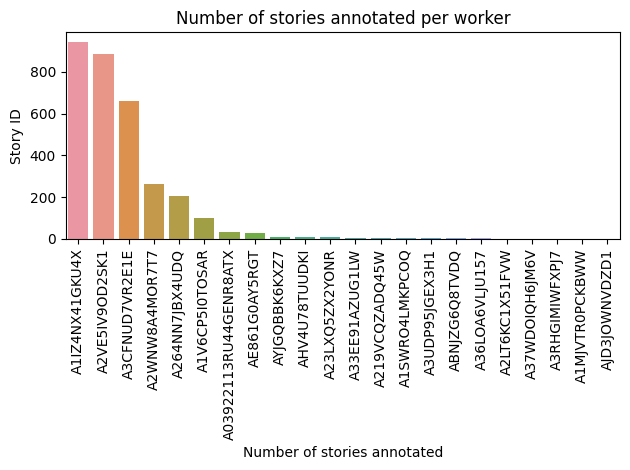

In [6]:
df = (
    HANNA_annotation.groupby("Worker ID")
    .agg({"Story ID": pd.Series.nunique})
    .sort_values(by="Story ID", ascending=False)
)
sns.barplot(data=df, x=df.index, y="Story ID")
plt.xlabel("Number of stories annotated")
plt.title("Number of stories annotated per worker")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
# Keep stories annotaded by the top 3 workers
top_3_workers = HANNA_annotation["Worker ID"].value_counts().index[:3]
HANNA_annotation = HANNA_annotation[HANNA_annotation["Worker ID"].isin(top_3_workers)]
HANNA_annotation = HANNA_annotation.groupby("Story ID").filter(lambda x: len(x) >= 3)
HANNA_annotation.head(2)

Story ID                                             Prompt  \
3         1  A new law is enacted that erases soldiers memo...   
4         1  A new law is enacted that erases soldiers memo...   

                                               Human  \
3  “Dad, you 're on TV again !” I heard Eric 's v...   
4  “Dad, you 're on TV again !” I heard Eric 's v...   

                                               Story  Model  Relevance  \
3  “Dad, you 're on TV again !” I heard Eric 's v...  Human          5   
4  “Dad, you 're on TV again !” I heard Eric 's v...  Human          5   

   Coherence  Empathy  Surprise  Engagement  Complexity       Worker ID  \
3          5        3         4           4           4  A3CFNUD7VR2E1E   
4          4        4         4           4           4  A2VE5IV9OD2SK1   

   Work time in seconds  
3                 117.0  
4                 751.0

Text(0.5, 1.0, 'Work time per worker')

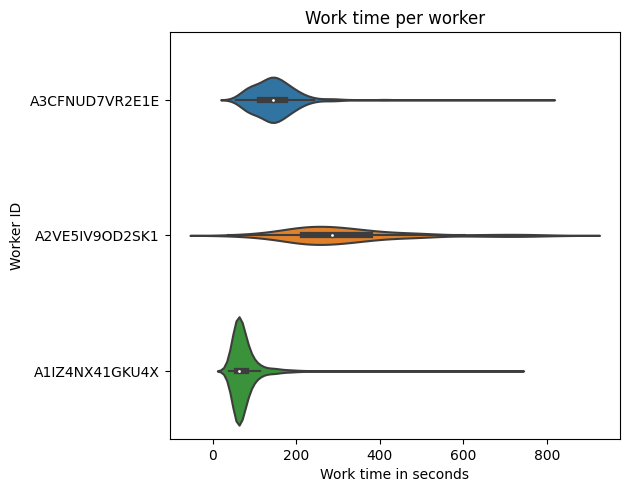

In [8]:
sns.violinplot(
    data=HANNA_annotation,
    x="Work time in seconds",
    y="Worker ID",
    order=HANNA_annotation["Worker ID"].value_counts().index,
    cmap="icefire",
)
plt.tight_layout()
plt.title("Work time per worker")

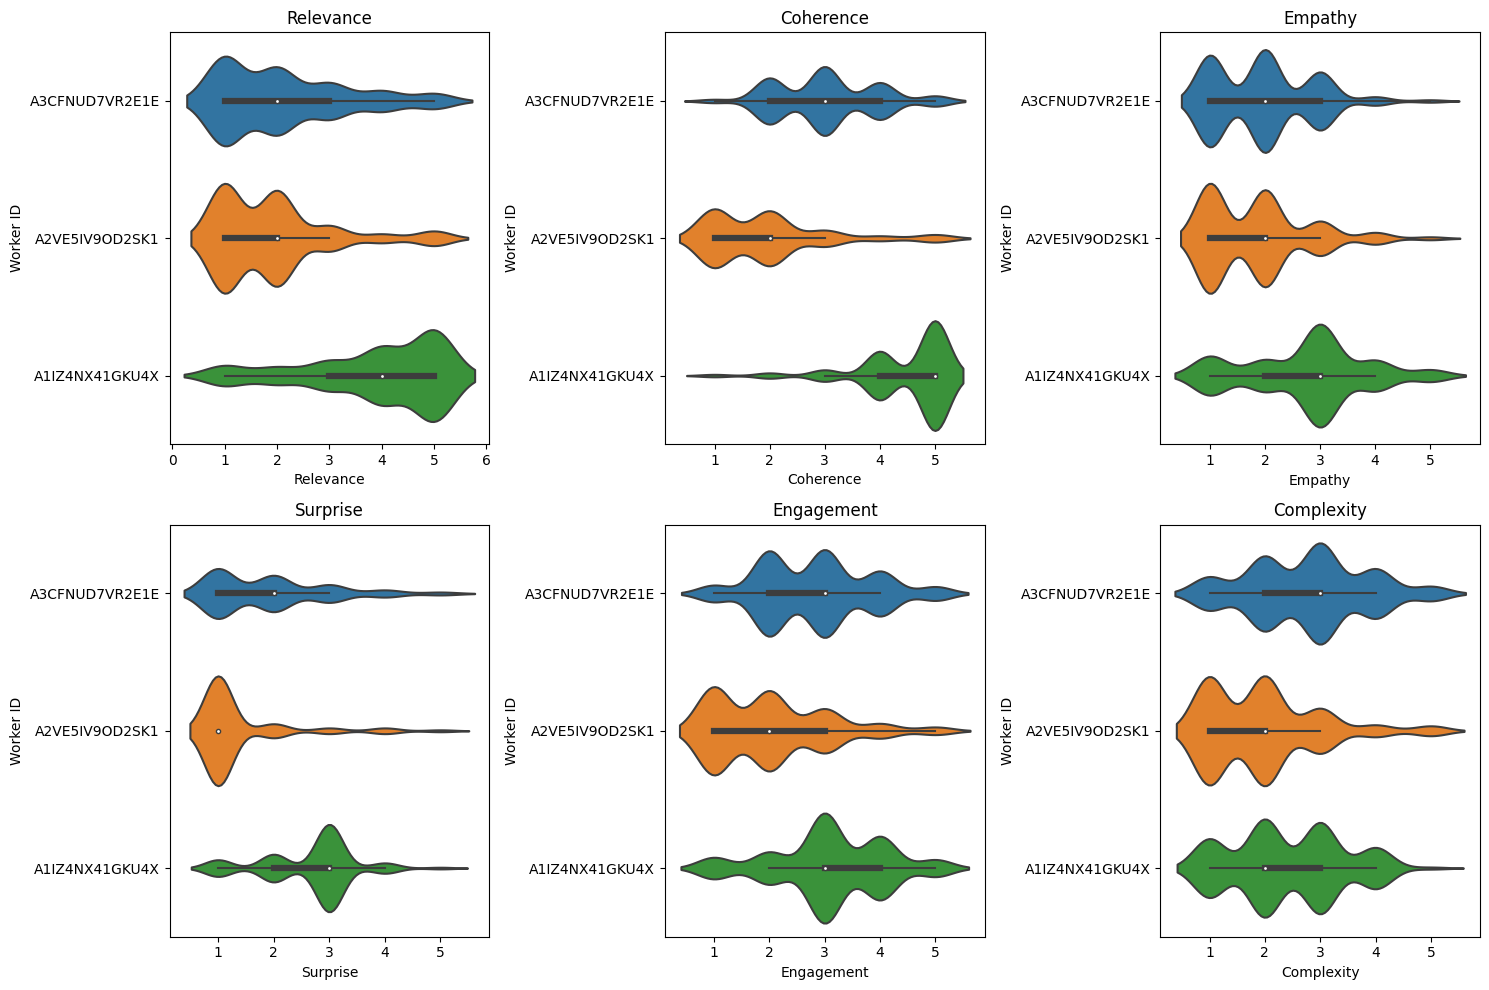

In [9]:
# sWorkers annotations tendance
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(list_criteria):
    sns.violinplot(
        data=HANNA_annotation,
        x=col,
        y="Worker ID",
        order=HANNA_annotation["Worker ID"].value_counts().index,
        ax=axes[i // 3, i % 3],
        cmap="icefire",
    )
    axes[i // 3, i % 3].set_title(col)
plt.tight_layout()
plt.show()

Correlation between workers A1IZ4NX41GKU4X and A2VE5IV9OD2SK1 over Surprise is significant: False


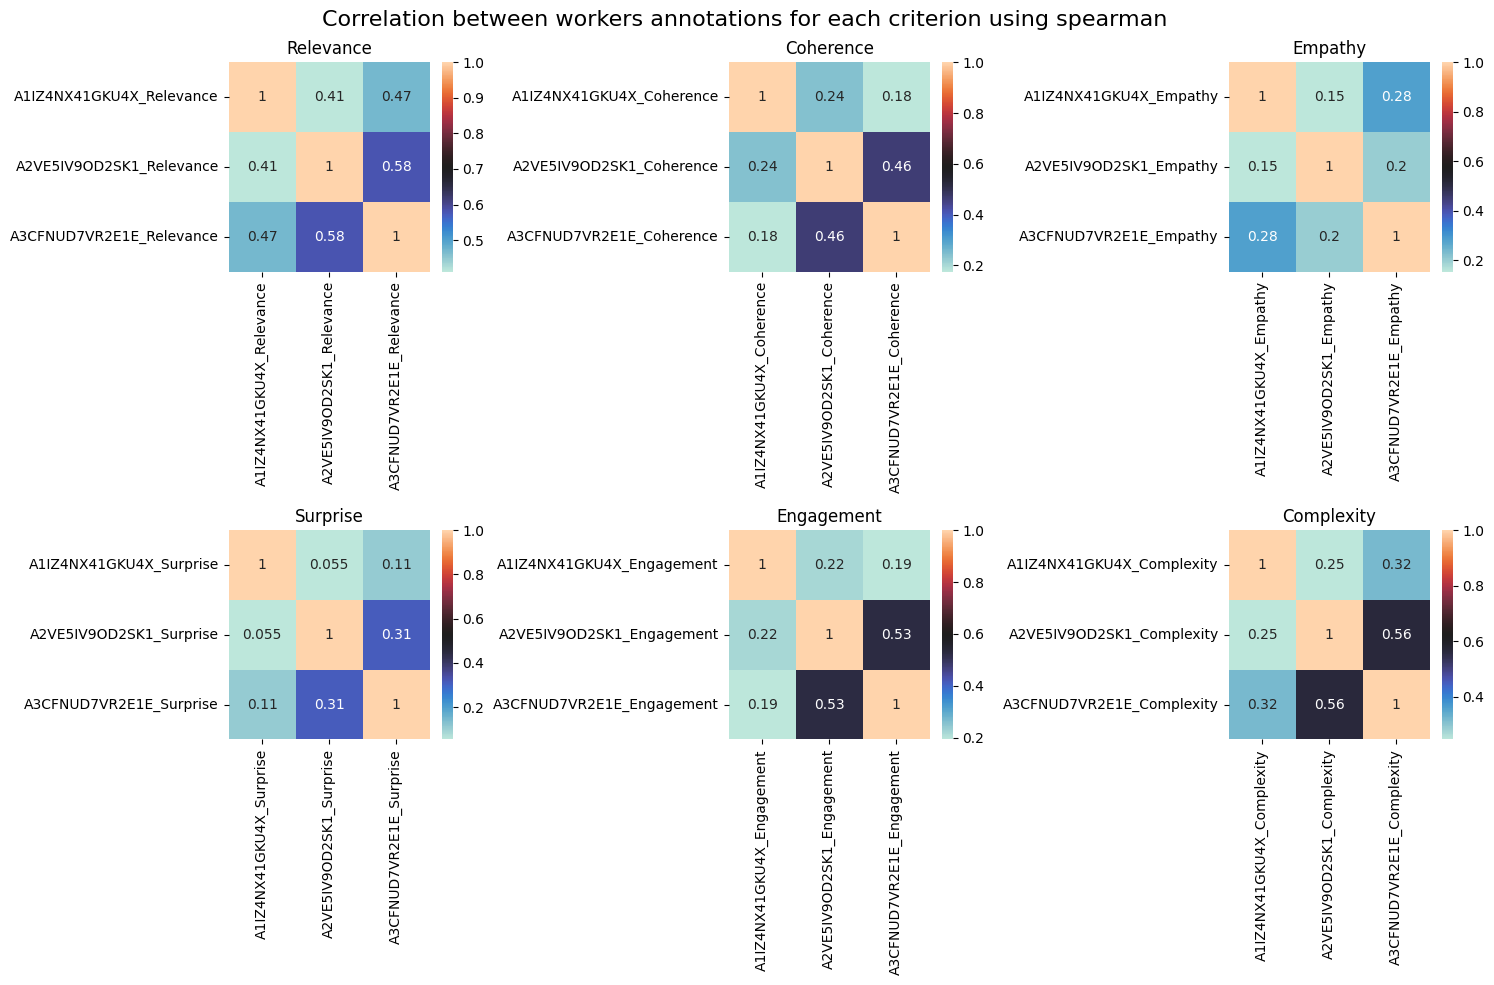

In [10]:
# compute the correlation between the 3 workers for each criterion
def plot_correlation_heatmap(df, correlation_type):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    # fig title
    fig.suptitle(
        "Correlation between workers annotations for each criterion using {}".format(
            correlation_type
        ),
        fontsize=16,
    )
    for i, criterion in enumerate(list_criteria):
        corr = coherence_3_workers(
            top_3_workers, criterion, HANNA_annotation, method=correlation_type
        )
        # ordinal columns: use kendalltau
        sns.heatmap(corr, annot=True, ax=axes[i // 3, i % 3], cmap="icefire")
        axes[i // 3, i % 3].set_title(criterion)
    plt.tight_layout()
    plt.show()


plot_correlation_heatmap(HANNA_annotation, "spearman")

Correlation between workers A1IZ4NX41GKU4X and A2VE5IV9OD2SK1 over Surprise is significant: False


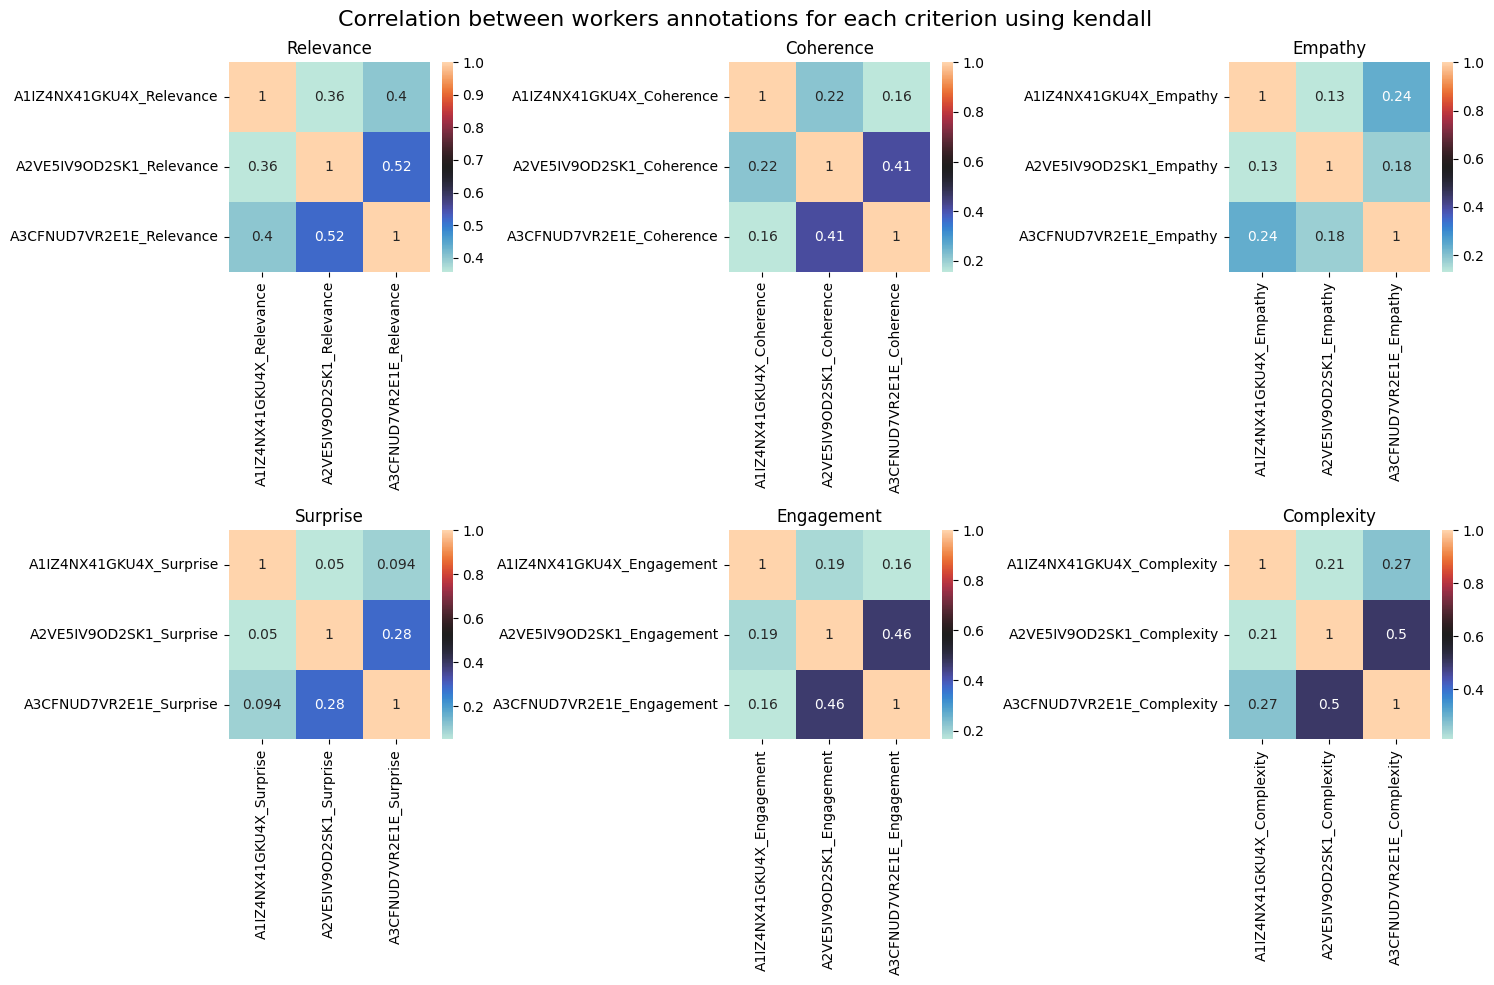

In [11]:
plot_correlation_heatmap(HANNA_annotation, "kendall")

Correlation between workers A1IZ4NX41GKU4X and A2VE5IV9OD2SK1 over Surprise is significant: False
Correlation between workers A1IZ4NX41GKU4X and A3CFNUD7VR2E1E over Surprise is significant: False


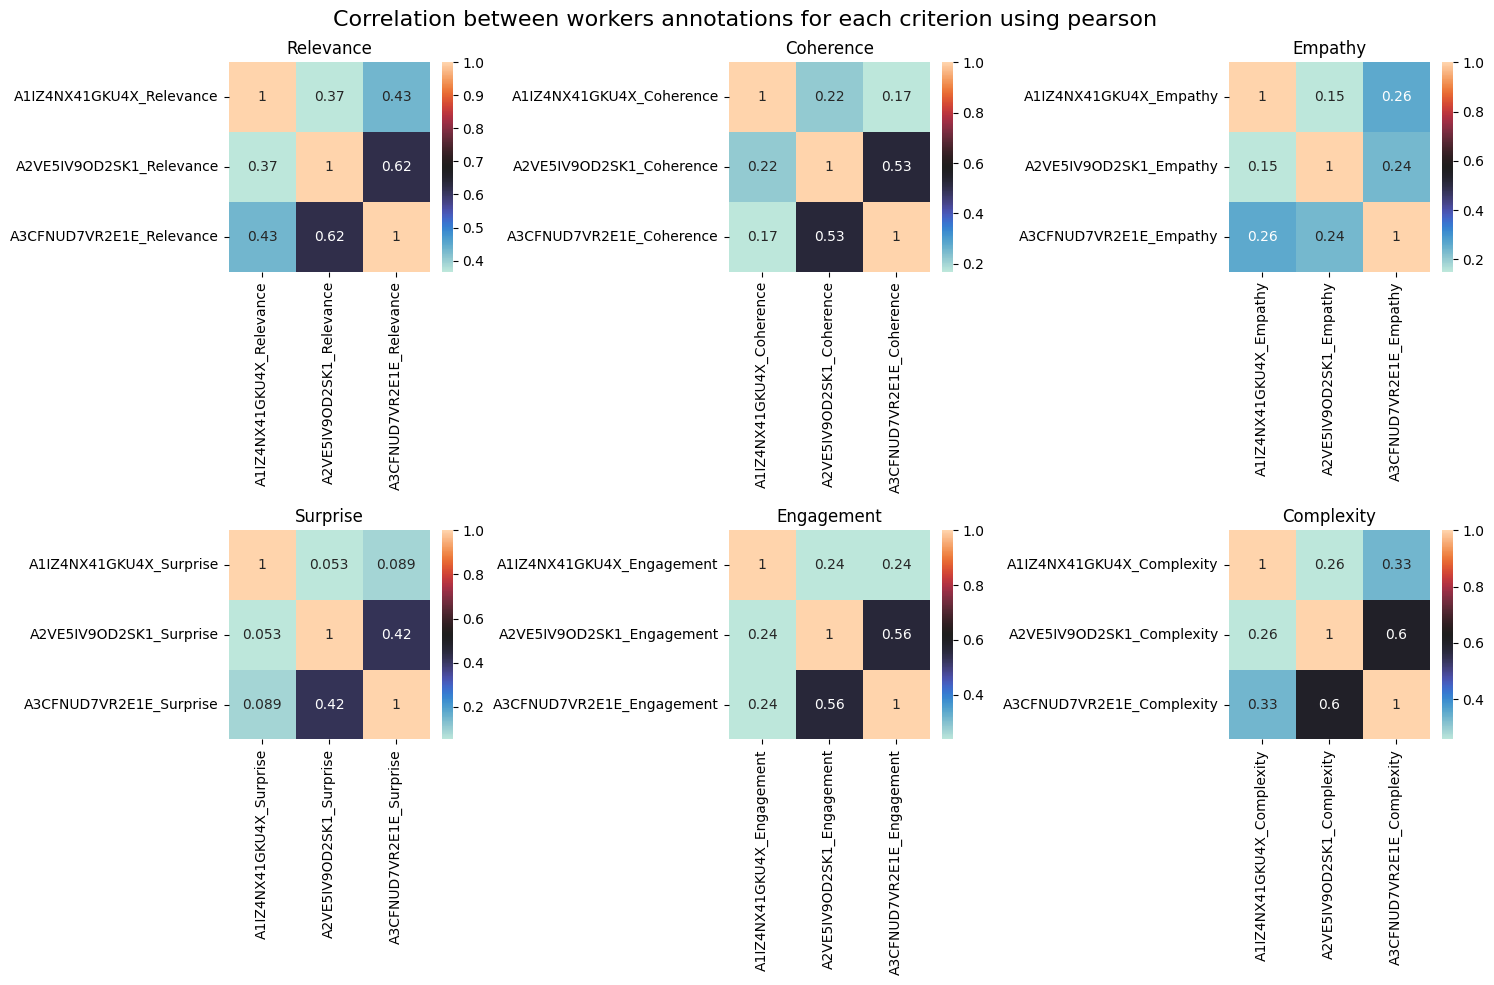

In [12]:
plot_correlation_heatmap(HANNA_annotation, "pearson")

## **Study Criteria**

In [15]:
HANNA_annotation_criteria = HANNA_annotation[list_criteria]
HANNA_annotation_criteria

Relevance  Coherence  Empathy  Surprise  Engagement  Complexity
3             5          5        3         4           4           4
4             5          4        4         4           4           4
5             5          5        5         3           3           4
27            5          5        4         5           5           3
28            2          4        3         5           4           4
...         ...        ...      ...       ...         ...         ...
3139          4          5        1         2           5           5
3140          5          5        3         3           2           3
3141          1          2        1         1           2           1
3142          1          2        2         1           1           1
3143          3          4        2         3           3           3

[1293 rows x 6 columns]

Correlation not significant for the following criteria pairs: set()
Correlation not significant for the following criteria pairs: set()
Correlation not significant for the following criteria pairs: set()


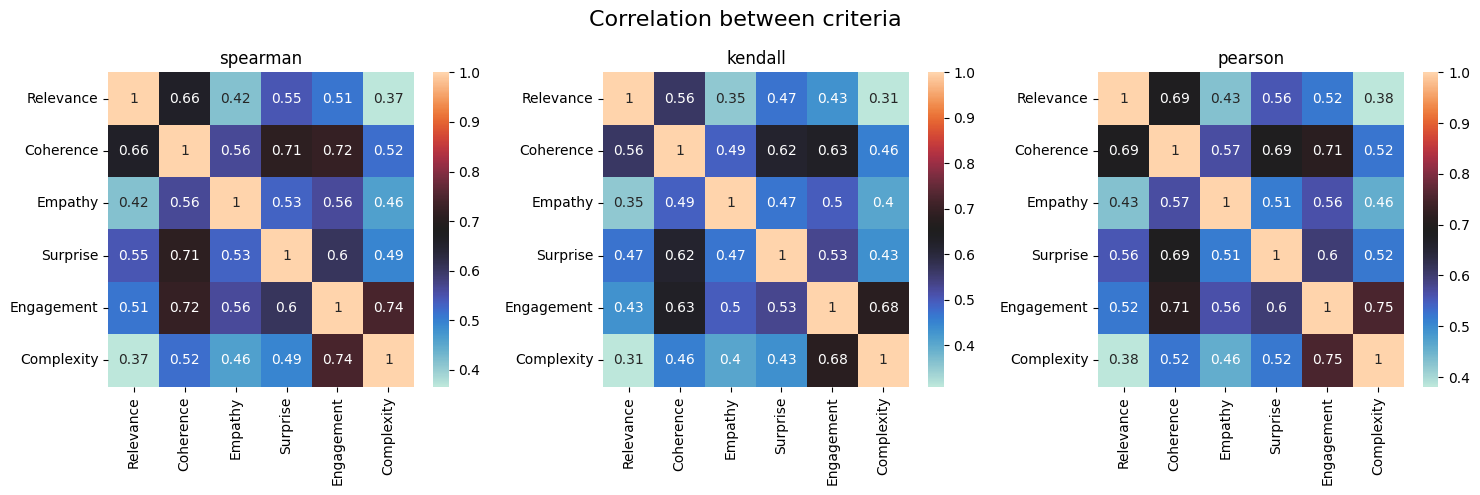

In [16]:
def critiria_correlation(df, correlation_type):
    correlation_criteria_kendal, _ = compute_criteria_correlation(
        HANNA_annotation_criteria, correlation_type
    )
    return correlation_criteria_kendal


# subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# fig title
for i, correlation_type in enumerate(["spearman", "kendall", "pearson"]):
    correlation_criteria = critiria_correlation(
        HANNA_annotation_criteria, correlation_type
    )
    sns.heatmap(correlation_criteria, annot=True, ax=axes[i], cmap="icefire")
    axes[i].set_title(correlation_type)
    fig.suptitle("Correlation between criteria", fontsize=16)
plt.tight_layout()
plt.show()

## **Study ASG**

In [17]:
HANNA_annotation_ASG = HANNA_annotation[["Model", "Story ID"] + list_criteria]
HANNA_annotation_ASG

Model  Story ID  Relevance  Coherence  Empathy  Surprise  Engagement  \
3      Human         1          5          5        3         4           4   
4      Human         1          5          4        4         4           4   
5      Human         1          5          5        5         3           3   
27     Human         9          5          5        4         5           5   
28     Human         9          2          4        3         5           4   
...      ...       ...        ...        ...      ...       ...         ...   
3139  TD-VAE      1046          4          5        1         2           5   
3140  TD-VAE      1046          5          5        3         3           2   
3141  TD-VAE      1047          1          2        1         1           2   
3142  TD-VAE      1047          1          2        2         1           1   
3143  TD-VAE      1047          3          4        2         3           3   

      Complexity  
3              4  
4              4  
5              4  
27             3  
28             4  
...          ...  
3139           5  
3140           3  
3141           1  
3142           1  
3143           3  

[1293 rows x 8 columns]

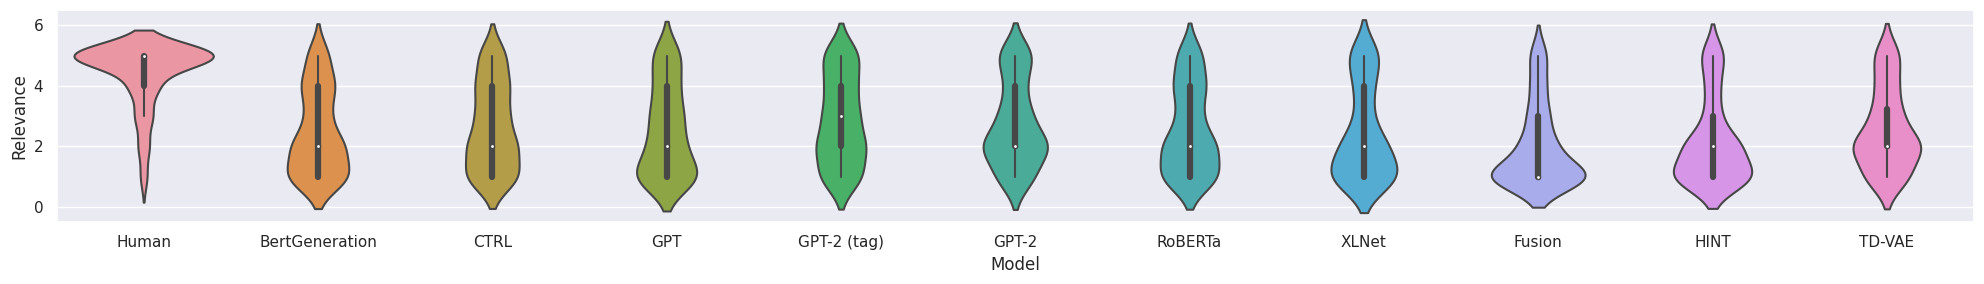

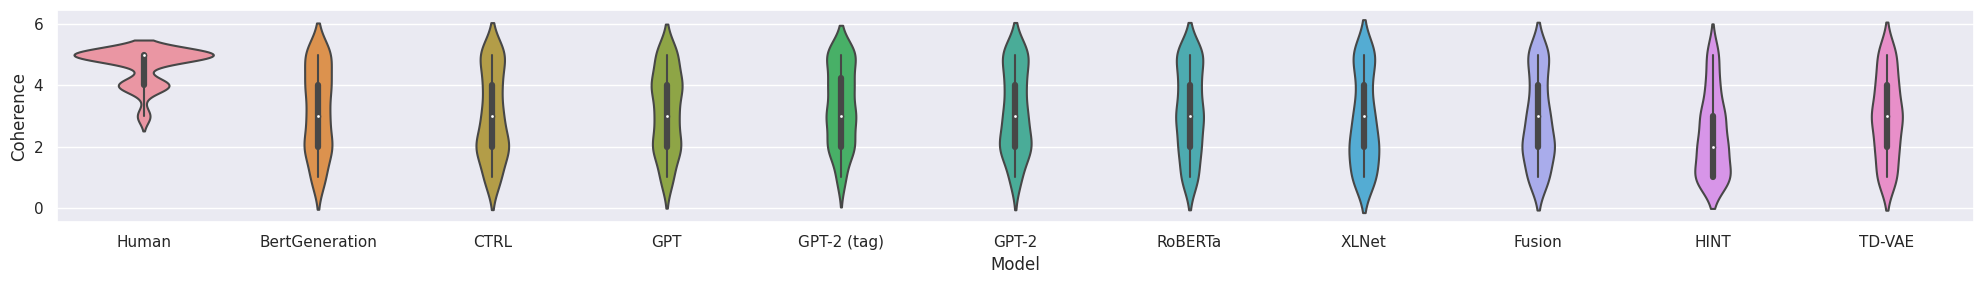

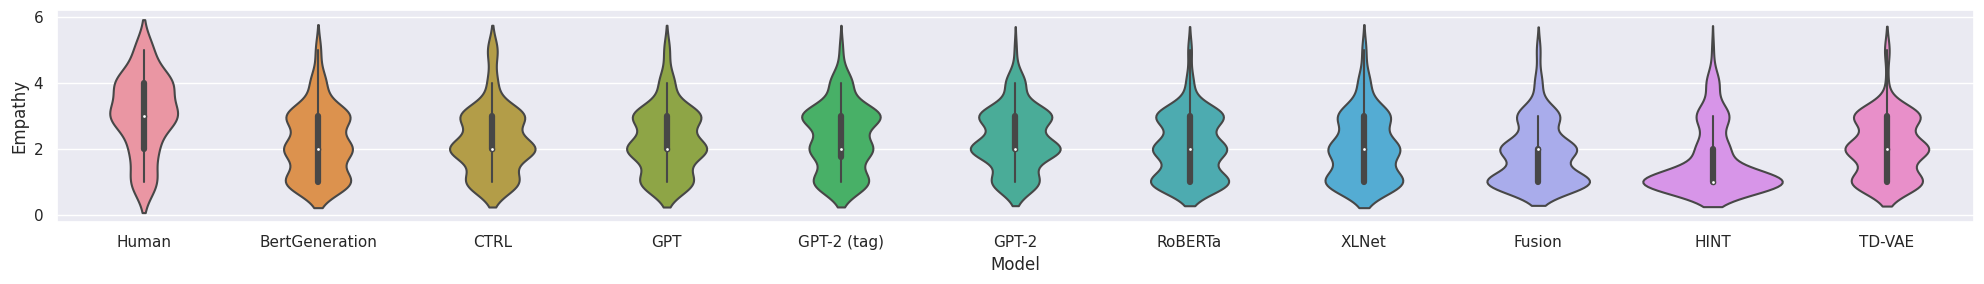

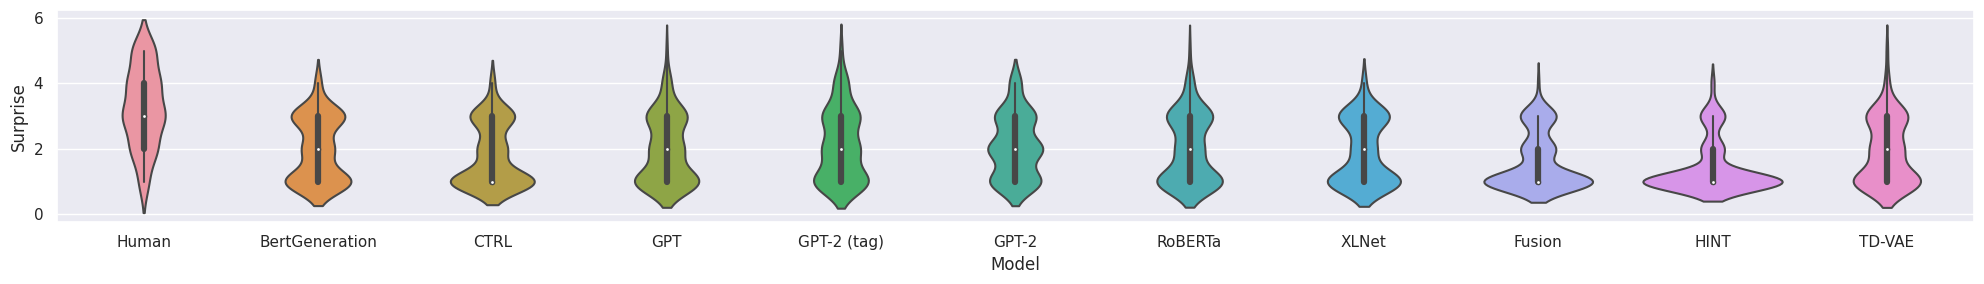

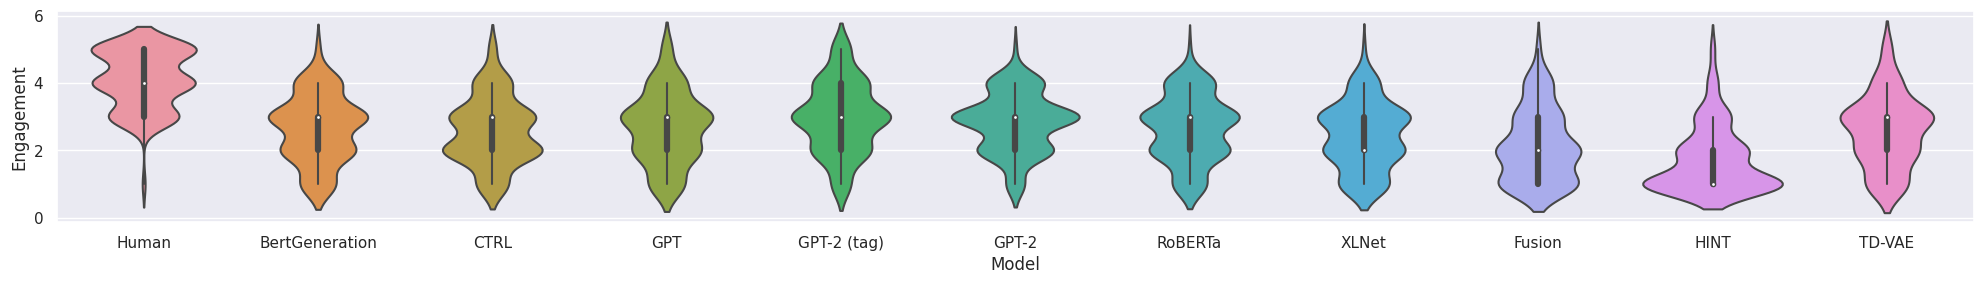

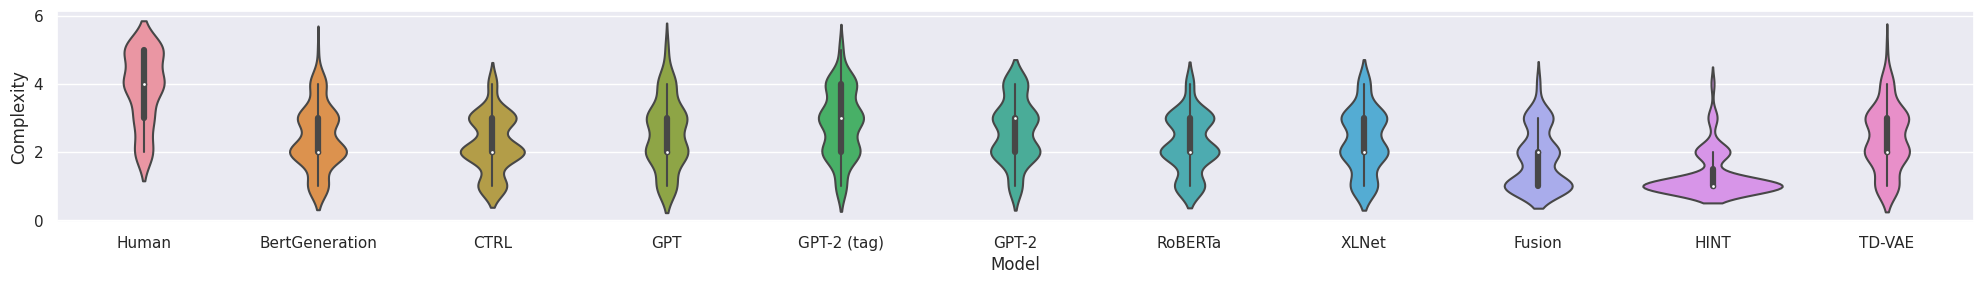

In [18]:
for criterion in list_criteria:
    sns.set(rc={"figure.figsize": (20, 3)})
    ax = sns.violinplot(x="Model", y=criterion, data=HANNA_annotation_ASG)
    plt.tight_layout()
    plt.show()

In [19]:
# Aggregate scores
HANNA_annotation_ASG_aggregated = (
    HANNA_annotation_ASG.groupby(["Model"]).mean().round(2)
)
HANNA_annotation_ASG_aggregated = HANNA_annotation_ASG_aggregated.drop(
    "Story ID", axis=1
)
HANNA_annotation_ASG_aggregated

Relevance  Coherence  Empathy  Surprise  Engagement  \
Model                                                                 
BertGeneration       2.48       3.17     2.21      2.00        2.66   
CTRL                 2.65       3.01     2.27      1.81        2.59   
Fusion               1.99       2.86     1.85      1.61        2.16   
GPT                  2.53       3.17     2.28      1.98        2.68   
GPT-2                2.73       3.16     2.31      2.08        2.82   
GPT-2 (tag)          2.85       3.33     2.35      2.12        2.98   
HINT                 2.16       2.44     1.64      1.43        1.73   
Human                4.42       4.62     3.07      3.25        4.09   
RoBERTa              2.56       3.17     2.06      2.00        2.65   
TD-VAE               2.56       2.97     2.06      1.92        2.59   
XLNet                2.43       2.85     2.05      1.91        2.44   

                Complexity  
Model                       
BertGeneration        2.41  
CTRL                  2.24  
Fusion                1.78  
GPT                   2.53  
GPT-2                 2.61  
GPT-2 (tag)           2.84  
HINT                  1.33  
Human                 3.85  
RoBERTa               2.24  
TD-VAE                2.40  
XLNet                 2.32

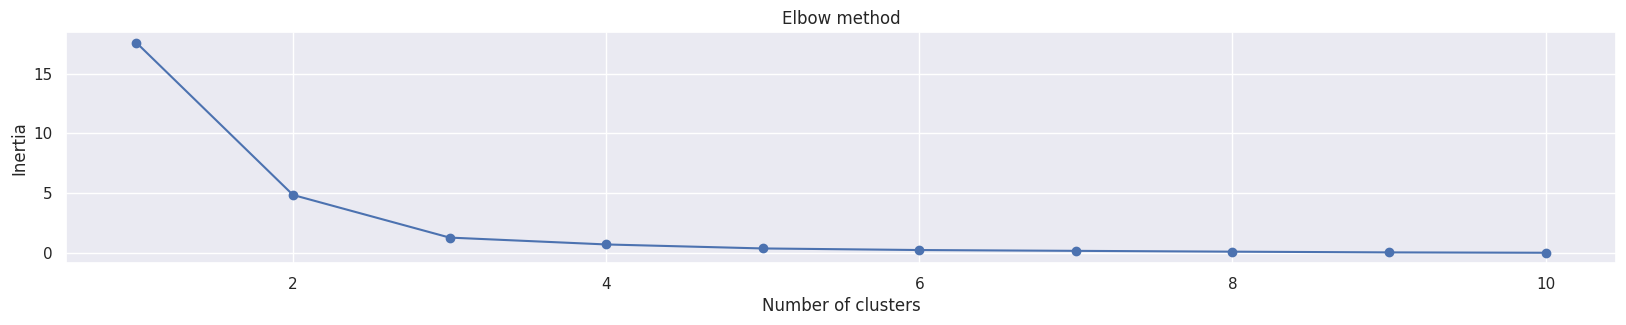

In [20]:
# cluster the ASG models
inertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(HANNA_annotation_ASG_aggregated)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker="o")
plt.title("Elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [21]:
# Plot the clusters using PCA
## PCA
pca = PCA(0.99)
pca_real = pd.DataFrame(pca.fit_transform(HANNA_annotation_ASG_aggregated))

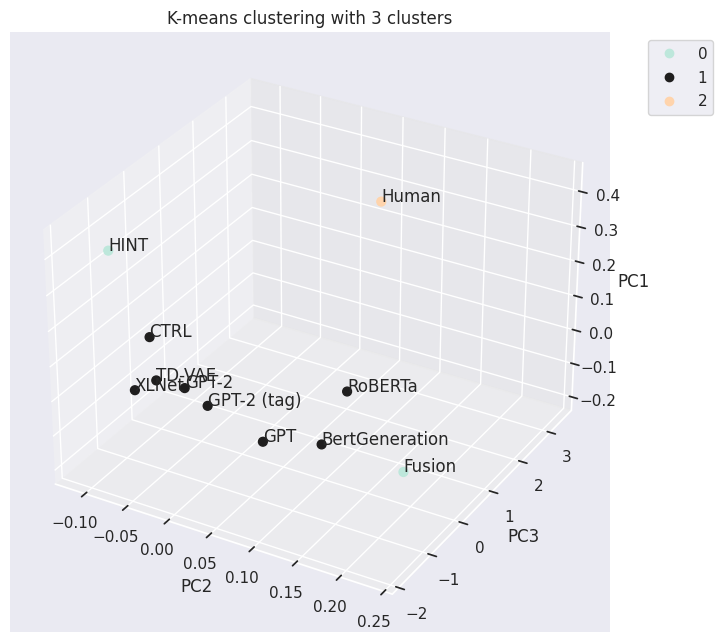

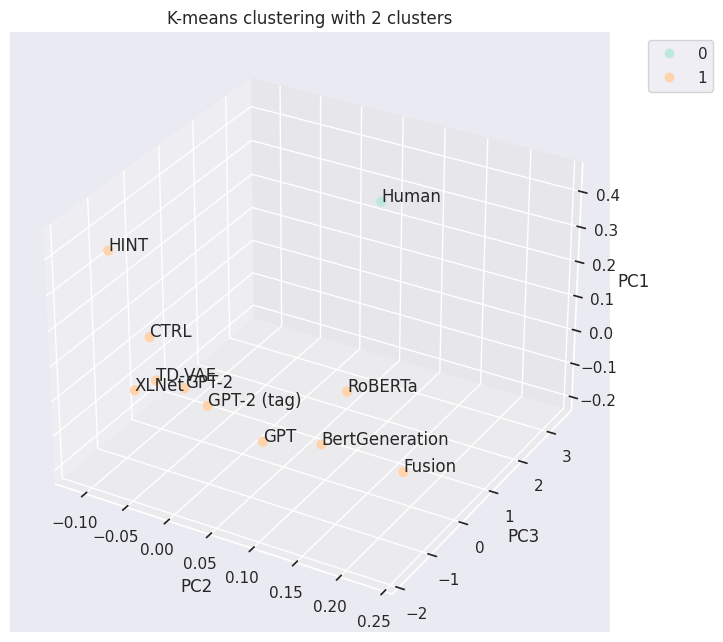

In [22]:
## Kmeans
def plot_clusters(pca_real, n_clusters, data):
    updated_kmeans_model = KMeans(
        n_clusters=n_clusters, init="k-means++", max_iter=500, random_state=42
    )
    pca_real["cluster"] = updated_kmeans_model.fit_predict(data)
    pca_real["Model"] = data.index
    ## Plot
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    sc = ax.scatter(
        pca_real.iloc[:, 2],
        pca_real.iloc[:, 0],
        pca_real.iloc[:, 1],
        s=40,
        c=pca_real.cluster,
        marker="o",
        alpha=1,
        cmap="icefire",
    )
    ax.set_zlabel("PC1")
    ax.set_xlabel("PC2")
    ax.set_ylabel("PC3")
    for i, txt in enumerate(pca_real["Model"]):
        ax.text(
            pca_real.iloc[i, 2],
            pca_real.iloc[i, 0],
            pca_real.iloc[i, 1],
            txt,
            fontsize=12,
        )
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
    plt.title("K-means clustering with {} clusters".format(n_clusters))
    plt.show()


plot_clusters(pca_real, 3, HANNA_annotation_ASG_aggregated)
plot_clusters(pca_real, 2, HANNA_annotation_ASG_aggregated)

# **Metrics Evaluation**


## **System Level**

In [26]:
metrics_scores = pd.read_csv("./data/hanna_metric_scores.csv")
# drop human generated stories scores
metrics_scores = metrics_scores.drop(0, axis=0)
metrics_scores.head(2)

Model                                          Relevance  \
1  BertGeneration  [1.6666666666666667, 3.0, 1.3333333333333333, ...   
2            CTRL  [2.3333333333333335, 3.6666666666666665, 2.666...   

                                           Coherence  \
1  [3.6666666666666665, 2.6666666666666665, 2.333...   
2  [3.0, 3.3333333333333335, 3.3333333333333335, ...   

                                             Empathy  \
1  [2.6666666666666665, 2.6666666666666665, 1.0, ...   
2  [2.3333333333333335, 3.3333333333333335, 3.333...   

                                            Surprise  \
1  [1.3333333333333333, 2.0, 1.6666666666666667, ...   
2  [2.6666666666666665, 1.3333333333333333, 3.0, ...   

                                          Engagement  \
1  [2.6666666666666665, 2.6666666666666665, 1.333...   
2  [2.6666666666666665, 3.3333333333333335, 3.333...   

                                          Complexity  \
1  [2.6666666666666665, 2.6666666666666665, 1.333...   
2  [2.6666666666666665, 3.0, 3.0, 2.3333333333333...   

                                             BLEU Ξ§  \
1  [1.4336111822, 1.4493826988, 0.1779090484, 0.1...   
2  [1.2558030838, 2.775216509, 0.400491848, 0.271...   

                                   ROUGE-1 Recall Ξ§  \
1  [0.38249, 0.24074, 0.16285, 0.13276, 0.40645, ...   
2  [0.29954, 0.30741, 0.18702, 0.19367, 0.23871, ...   

                                ROUGE-1 Precision Ξ§  ...  \
1  [0.37054, 0.26639, 0.59259, 0.56771, 0.26923, ...  ...   
2  [0.38922, 0.3547, 0.54444, 0.60456, 0.30833, 0...  ...   

                                     Repetition-2 ¤§  \
1  [0.08888888888888889, 0.0546875, 0.05676855895...   
2  [0.042328042328042326, 0.09154929577464789, 0....   

                                     Repetition-3 ¤§  \
1  [0.044534412955465584, 0.022641509433962263, 0...   
2  [0.01020408163265306, 0.01910828025477707, 0.0...   

                                        SUPERT-PS ¤ε  \
1  [0.2597054082262463, 0.20473734339818345, 0.24...   
2  [0.25552435405490376, 0.1820114012358586, 0.30...   

                                        SUPERT-SS ¤ε  \
1  [0.3097425349207481, 0.20473734339818345, 0.24...   
2  [0.25552435405490376, 0.14368366145385317, 0.2...   

                                    BLANC-Tune-PS ¤Δ  \
1  [-0.01834862385321101, -0.014184397163120567, ...   
2  [0.0, 0.008333333333333333, -0.011904761904761...   

                                    BLANC-Help-PS ¤Δ  \
1  [-0.03669724770642202, -0.02127659574468085, -...   
2  [-0.012345679012345678, -0.008333333333333333,...   

                                    BLANC-Tune-SS ¤Δ  \
1  [-0.058823529411764705, -0.2857142857142857, 0...   
2  [-0.058823529411764705, 0.0, 0.0, 0.0, 0.0, 0....   

                                    BLANC-Help-SS ¤Δ  \
1  [-0.058823529411764705, -0.14285714285714285, ...   
2  [-0.058823529411764705, -0.14285714285714285, ...   

                                     BARTScore-PS ¤Δ  \
1  [-3.913217067718506, -5.507814407348633, -4.62...   
2  [-5.204783916473389, -4.947543144226074, -4.69...   

                                     BARTScore-SP ¤Δ  
1  [-4.915536880493164, -6.616286277770996, -5.14...  
2  [-4.883750915527344, -6.809321403503418, -4.91...  

[2 rows x 79 columns]

Correlation not significant for the following metric pairs: {('Surprise', 'SummaQA ΞΔ'), ('Relevance', 'ROUGE-4 Precision Ξ§'), ('Relevance', 'SummaQA ΞΔ'), ('Relevance', 'BARTScore-HS ΞΔ'), ('Engagement', 'ROUGE-4 F-Score Ξ§'), ('Coherence', 'SUPERT-SS ¤ε'), ('Engagement', 'ROUGE-S* F-Score Ξ§'), ('Coherence', 'BLANC-Tune-PS ¤Δ'), ('Surprise', 'InfoLM-FisherRao ΞΔ'), ('Complexity', 'ROUGE-WE-3 F-Score Ξε'), ('Empathy', 'ROUGE-1 Precision Ξ§'), ('Complexity', 'SUPERT-PS ¤ε'), ('Coherence', 'S3-Pyramid ΞΔ'), ('Engagement', 'ROUGE-SU* Precision Ξ§'), ('Coherence', 'InfoLM-R-FisherRao ΞΔ'), ('Surprise', 'ROUGE-WE-3 F-Score Ξε'), ('Engagement', 'ROUGE-S* Precision Ξ§'), ('Coherence', 'BLANC-Golden ΞΔ'), ('Surprise', 'SUPERT-PS ¤ε'), ('Coherence', 'S3-Responsiveness ΞΔ'), ('Complexity', 'ROUGE-W-1.2 Precision Ξ§'), ('Complexity', 'ROUGE-L Precision Ξ§'), ('Relevance', 'SUPERT-PS ¤ε'), ('Complexity', 'Repetition-3 ¤§'), ('Empathy', 'ROUGE-2 F-Score Ξ§'), ('Surprise', 'ROUGE-W-1.2 Precision Ξ

/tmp/ipykernel_20470/2149006712.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


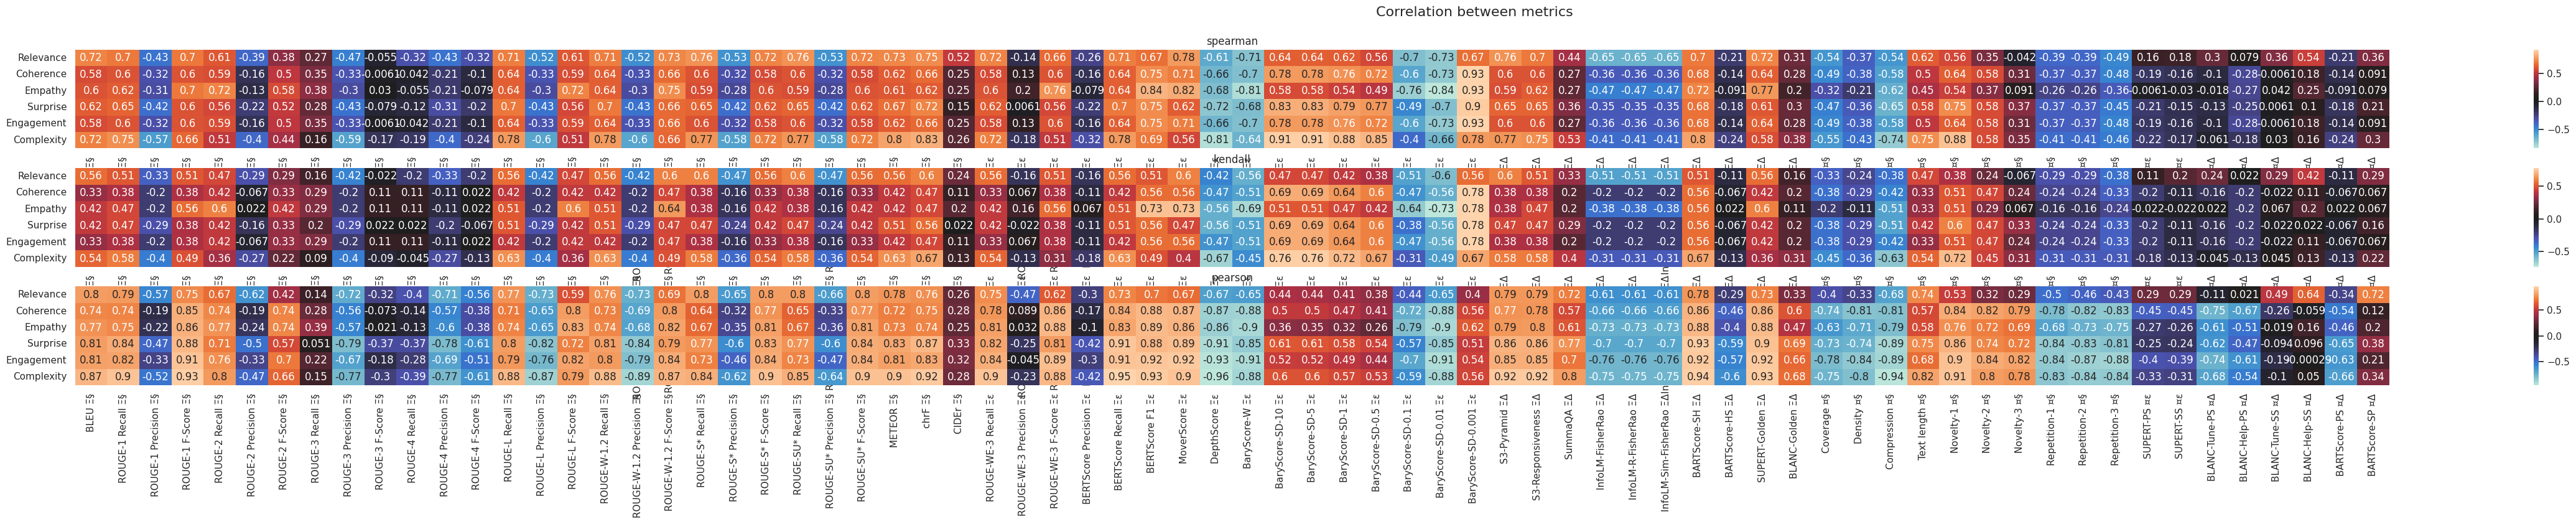

In [32]:
# heatmap of the correlation between the metrics for all correlation types
fig, axes = plt.subplots(3, 1, figsize=(60, 7))
for i, correlation_type in enumerate(["spearman", "kendall", "pearson"]):
    correlation_metrics = get_all_system_level_correlation(
        metrics_scores, correlation_type
    )
    sns.heatmap(correlation_metrics, annot=True, ax=axes[i], cmap="icefire")
    axes[i].set_title(correlation_type)
    fig.suptitle("Correlation between metrics", fontsize=16)
plt.tight_layout()
plt.show()

## **Story-level Correlation**

/home/soukaina/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/soukaina/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_20470/3655176523.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


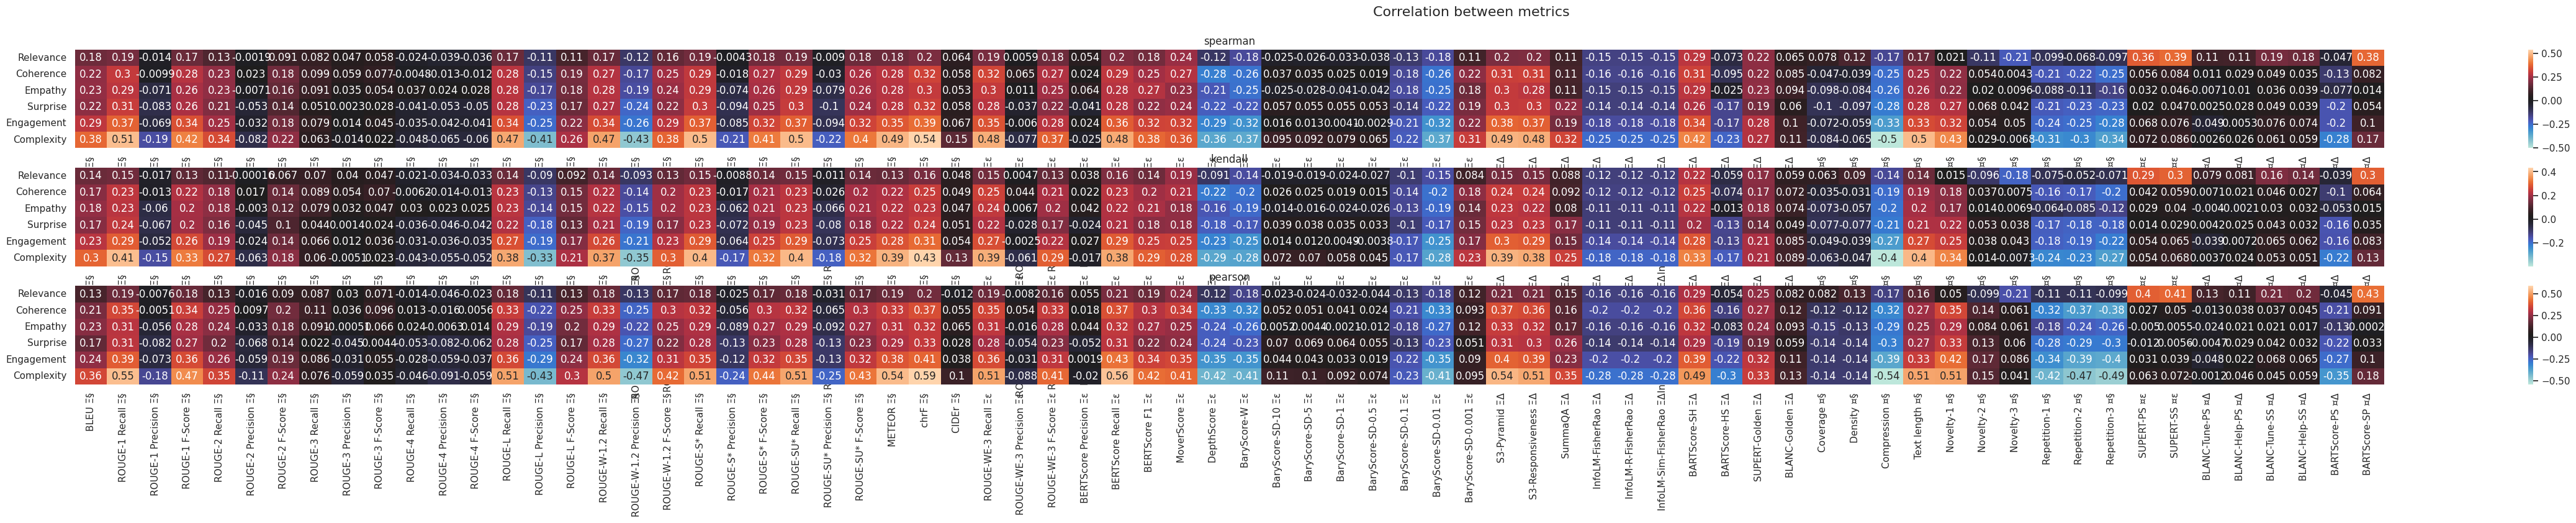

In [37]:
# story level correlation subplots
fig, axes = plt.subplots(3, 1, figsize=(60, 7))
for i, correlation_type in enumerate(["spearman", "kendall", "pearson"]):
    correlation_metrics = get_all_story_level_correlation(
        metrics_scores, correlation_type
    )
    sns.heatmap(correlation_metrics, annot=True, ax=axes[i], cmap="icefire")
    axes[i].set_title(correlation_type)
    fig.suptitle("Correlation between metrics", fontsize=16)
plt.tight_layout()
plt.show()

# **Select best metric**

In [68]:
# best_metrics_system_level_spearman = metrics_ranking(metrics_scores, "system", "spearman", list_criteria, 10)
# best_metrics_system_level_pearson = metrics_ranking(metrics_scores, "system", "pearson", list_criteria, 10)
best_metrics_system_level_keandall = metrics_ranking(
    metrics_scores, "system", "kendall", list_criteria, 10
)["bordas_rank"]
best_metrics_story_level_keandall = metrics_ranking(
    metrics_scores, "story", "kendall", list_criteria, 10
)["bordas_rank"]

Correlation not significant for the following metric pairs: {('Surprise', 'SummaQA ΞΔ'), ('Relevance', 'ROUGE-4 Precision Ξ§'), ('Relevance', 'SummaQA ΞΔ'), ('Relevance', 'BARTScore-HS ΞΔ'), ('Engagement', 'ROUGE-4 F-Score Ξ§'), ('Coherence', 'SUPERT-SS ¤ε'), ('Engagement', 'ROUGE-S* F-Score Ξ§'), ('Coherence', 'BLANC-Tune-PS ¤Δ'), ('Surprise', 'InfoLM-FisherRao ΞΔ'), ('Complexity', 'ROUGE-WE-3 F-Score Ξε'), ('Empathy', 'ROUGE-1 Precision Ξ§'), ('Complexity', 'SUPERT-PS ¤ε'), ('Coherence', 'S3-Pyramid ΞΔ'), ('Engagement', 'ROUGE-SU* Precision Ξ§'), ('Coherence', 'InfoLM-R-FisherRao ΞΔ'), ('Surprise', 'ROUGE-WE-3 F-Score Ξε'), ('Engagement', 'ROUGE-S* Precision Ξ§'), ('Coherence', 'BLANC-Golden ΞΔ'), ('Surprise', 'SUPERT-PS ¤ε'), ('Surprise', 'ROUGE-1 Recall Ξ§'), ('Coherence', 'S3-Responsiveness ΞΔ'), ('Complexity', 'ROUGE-W-1.2 Precision Ξ§'), ('Complexity', 'ROUGE-L Precision Ξ§'), ('Relevance', 'SUPERT-PS ¤ε'), ('Complexity', 'Repetition-3 ¤§'), ('Coherence', 'BERTScore Recall Ξε'),

In [92]:
best_metrics_system_level_keandall

Relevance  Coherence  Empathy  Surprise  Engagement  \
BaryScore-SD-0.001 Ξε        11.5        1.0      1.0       1.0         1.0   
BaryScore-SD-10 Ξε           25.0        2.5     13.5       2.5         2.5   
BaryScore-SD-5 Ξε            25.0        2.5     13.5       2.5         2.5   
BARTScore-SH ΞΔ              19.5        7.0      9.0       8.0         7.0   
chrF Ξ§                       3.5       11.0     18.5       8.0        11.0   
BaryScore-SD-1 Ξε            28.5        4.0     18.5       4.0         4.0   
MoverScore Ξε                 3.5        7.0      2.5      17.5         7.0   
BERTScore F1 Ξε              19.5        7.0      2.5       8.0         7.0   
Novelty-1 ¤§                 30.5        9.0     13.5       5.5         9.0   
ROUGE-W-1.2 F-Score Ξ§        3.5       11.0      4.0      17.5        11.0   

                        Complexity  bordas_rank  
BaryScore-SD-0.001 Ξε          6.5         22.0  
BaryScore-SD-10 Ξε             1.5         47.5  
BaryScore-SD-5 Ξε              1.5         47.5  
BARTScore-SH ΞΔ                6.5         57.0  
chrF Ξ§                        6.5         58.5  
BaryScore-SD-1 Ξε              3.5         62.5  
MoverScore Ξε                 27.5         65.0  
BERTScore F1 Ξε               24.0         68.0  
Novelty-1 ¤§                   3.5         71.0  
ROUGE-W-1.2 F-Score Ξ§        24.0         71.0

In [93]:
best_metrics_story_level_keandall

Relevance  Coherence  Empathy  Surprise  Engagement  \
chrF Ξ§                     9.0        3.0      2.0       1.0         1.0   
ROUGE-1 Recall Ξ§          13.0        6.0      7.0       2.0         3.0   
S3-Pyramid ΞΔ              11.0        4.0      3.0       6.0         2.0   
S3-Responsiveness ΞΔ       10.0        5.0      9.0       3.0         4.0   
ROUGE-WE-3 Recall Ξε       12.0        1.0      1.0       8.0        11.0   
ROUGE-SU* Recall Ξ§        15.0        8.0      4.0       4.0         7.0   
ROUGE-S* Recall Ξ§         14.0        7.0      5.0       5.0         6.0   
BARTScore-SH ΞΔ             4.0        2.0     10.0      14.0         8.0   
BERTScore Recall Ξε         7.0       10.0     12.0      12.0         5.0   
ROUGE-L Recall Ξ§          19.0        9.0      6.0       9.0        10.0   

                      Complexity  bordas_rank  
chrF Ξ§                      1.0         17.0  
ROUGE-1 Recall Ξ§            2.0         33.0  
S3-Pyramid ΞΔ                7.0         33.0  
S3-Responsiveness ΞΔ         9.0         40.0  
ROUGE-WE-3 Recall Ξε         8.0         41.0  
ROUGE-SU* Recall Ξ§          3.0         41.0  
ROUGE-S* Recall Ξ§           5.0         42.0  
BARTScore-SH ΞΔ             14.0         52.0  
BERTScore Recall Ξε         10.0         56.0  
ROUGE-L Recall Ξ§           11.0         64.0

# **Select Best ASG**

In [113]:
# Select the best models according to the human scores
ASG_ranking_human = ASG_ranking_human_criteria(
    HANNA_annotation_ASG_aggregated, list_criteria
)
ASG_ranking_human

Relevance  Coherence  Empathy  Surprise  Engagement  \
Model                                                                 
Human                 1.0        1.0      1.0       1.0         1.0   
GPT-2 (tag)           2.0        2.0      2.0       2.0         2.0   
GPT-2                 3.0        6.0      3.0       3.0         3.0   
GPT                   7.0        4.0      4.0       6.0         4.0   
BertGeneration        8.0        4.0      6.0       4.5         5.0   
RoBERTa               5.5        4.0      7.5       4.5         6.0   
CTRL                  4.0        7.0      5.0       9.0         7.5   
TD-VAE                5.5        8.0      7.5       7.0         7.5   
XLNet                 9.0       10.0      9.0       8.0         9.0   
Fusion               11.0        9.0     10.0      10.0        10.0   
HINT                 10.0       11.0     11.0      11.0        11.0   

                Complexity  bordas_rank_human_criteria  
Model                                                   
Human                  1.0                         6.0  
GPT-2 (tag)            2.0                        12.0  
GPT-2                  3.0                        21.0  
GPT                    4.0                        29.0  
BertGeneration         5.0                        32.5  
RoBERTa                8.5                        36.0  
CTRL                   8.5                        41.0  
TD-VAE                 6.0                        41.5  
XLNet                  7.0                        52.0  
Fusion                10.0                        60.0  
HINT                  11.0                        65.0

In [116]:
## Select the best models according to the best metric
best_metric = best_metrics_story_level_keandall["bordas_rank"].idxmax()

ASG_ranking_human[best_metric] = np.mean(
    np.array(
        [
            json.loads(l)
            for l in pd.read_csv("./data/hanna_metric_scores.csv")[best_metric].tolist()
        ]
    ).T,
    axis=0,
)
ASG_ranking_human.sort_values(by=best_metric, ascending=False)

Relevance  Coherence  Empathy  Surprise  Engagement  \
Model                                                                 
Human                 1.0        1.0      1.0       1.0         1.0   
RoBERTa               5.5        4.0      7.5       4.5         6.0   
BertGeneration        8.0        4.0      6.0       4.5         5.0   
TD-VAE                5.5        8.0      7.5       7.0         7.5   
HINT                 10.0       11.0     11.0      11.0        11.0   
GPT-2 (tag)           2.0        2.0      2.0       2.0         2.0   
CTRL                  4.0        7.0      5.0       9.0         7.5   
GPT-2                 3.0        6.0      3.0       3.0         3.0   
GPT                   7.0        4.0      4.0       6.0         4.0   
XLNet                 9.0       10.0      9.0       8.0         9.0   
Fusion               11.0        9.0     10.0      10.0        10.0   

                Complexity  bordas_rank_human_criteria  ROUGE-L Recall Ξ§mean  \
Model                                                                           
Human                  1.0                         6.0               1.000000   
RoBERTa                8.5                        36.0               0.128715   
BertGeneration         5.0                        32.5               0.120217   
TD-VAE                 6.0                        41.5               0.117455   
HINT                  11.0                        65.0               0.105117   
GPT-2 (tag)            2.0                        12.0               0.098078   
CTRL                   8.5                        41.0               0.096436   
GPT-2                  3.0                        21.0               0.095674   
GPT                    4.0                        29.0               0.089292   
XLNet                  7.0                        52.0               0.079503   
Fusion                10.0                        60.0               0.061287   

                ROUGE-L Recall Ξ§  
Model                              
Human                    1.000000  
RoBERTa                  0.128715  
BertGeneration           0.120217  
TD-VAE                   0.117455  
HINT                     0.105117  
GPT-2 (tag)              0.098078  
CTRL                     0.096436  
GPT-2                    0.095674  
GPT                      0.089292  
XLNet                    0.079503  
Fusion                   0.061287